## Imports and setup

In [1]:
import os
import glob
import time
import torch
import csv
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from tqdm import tqdm
from skimage import measure
from torch.cuda.amp import GradScaler, autocast

from monai.data import decollate_batch, Dataset, DataLoader
from monai.networks.nets import HoVerNet
from monai.metrics import DiceMetric
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    TorchVisiond,
    Lambdad,
    Activations,
    OneOf,
    MedianSmoothd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    CastToTyped,
    ComputeHoVerMapsd,
    ScaleIntensityRanged,
    RandGaussianNoised,
    RandFlipd,
    RandAffined,
    RandGaussianSmoothd,
    CenterSpatialCropd,
)
from monai.apps.pathology.transforms import HoVerNetInstanceMapPostProcessingd, HoVerNetNuclearTypePostProcessingd
from monai.apps.pathology.losses.hovernet_loss import HoVerNetLoss
from monai.apps.pathology.inferers import SlidingWindowHoVerNetInferer

from monai.transforms.utils import apply_transform
from monai.utils import set_determinism, first
from monai.utils.enums import HoVerNetBranch

print('Imports Complete!')

Imports Complete!


In [2]:
# GPU details

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

NVIDIA RTX A6000
NVIDIA RTX A6000
NVIDIA RTX A6000
NVIDIA RTX A6000


In [3]:
# Parameters

train_dir = 'data/exp3/train_sub1_rm_ri/'
test_dir = 'data/test/'
model_dir = 'model/exp3/train_sub1_rm_ri/run_e100_bs16/'
max_epochs = 100
batch_size = 16
num_workers = 4
out_classes = 7
pretrained_model = "https://drive.google.com/u/1/uc?id=1KntZge40tAHgyXmHYVqZZ5d2p_4Qr2l5&export=download"
set_determinism(seed=42)

## Dataset Path

In [4]:
def prepare_data(data_dir):
    # prepare datalist
    images = sorted(glob.glob(os.path.join(data_dir, "*image.npy")))
    inst_maps = sorted(glob.glob(os.path.join(data_dir, "*inst_map.npy")))
    type_maps = sorted(glob.glob(os.path.join(data_dir, "*type_map.npy")))

    data_dicts = [
        {"image": _image, "label_inst": _inst_map, "label_type": _type_map}
        for _image, _inst_map, _type_map in zip(images, inst_maps, type_maps)
    ]

    return data_dicts

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label_inst", "label_type"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label_inst", "label_type"], channel_dim=-1),
        Lambdad(keys="label_inst", func=lambda x: measure.label(x)),
        RandAffined(
            keys=["image", "label_inst", "label_type"],
            prob=1.0,
            rotate_range=((np.pi), 0),
            scale_range=((0.2), (0.2)),
            shear_range=((0.05), (0.05)),
            translate_range=((6), (6)),
            padding_mode="zeros",
            mode=("nearest"),
        ),
        CenterSpatialCropd(
            keys="image",
            roi_size=(256, 256),
        ),
        RandFlipd(keys=["image", "label_inst", "label_type"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label_inst", "label_type"], prob=0.5, spatial_axis=1),
        OneOf(
            transforms=[
                RandGaussianSmoothd(keys=["image"], sigma_x=(0.1, 1.1), sigma_y=(0.1, 1.1), prob=1.0),
                MedianSmoothd(keys=["image"], radius=1),
                RandGaussianNoised(keys=["image"], prob=1.0, std=0.05),
            ]
        ),
        CastToTyped(keys="image", dtype=np.uint8),
        TorchVisiond(
            keys=["image"],
            name="ColorJitter",
            brightness=(229 / 255.0, 281 / 255.0),
            contrast=(0.95, 1.10),
            saturation=(0.8, 1.2),
            hue=(-0.04, 0.04),
        ),
        AsDiscreted(keys=["label_type"], to_onehot=[out_classes]),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        CastToTyped(keys="label_inst", dtype=torch.int),
        ComputeHoVerMapsd(keys="label_inst"),
        Lambdad(keys="label_inst", func=lambda x: x > 0, overwrite="label"),
        CenterSpatialCropd(
            keys=["label", "hover_label_inst", "label_inst", "label_type"],
            roi_size=(164, 164),
        ),
        AsDiscreted(keys=["label"], to_onehot=2),
        CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
    ]
)
           
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label_inst", "label_type"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label_inst", "label_type"], channel_dim=-1),
        Lambdad(keys="label_inst", func=lambda x: measure.label(x)),
        CastToTyped(keys=["image", "label_inst"], dtype=torch.int),
        CenterSpatialCropd(
            keys="image",
            roi_size=(256, 256),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        ComputeHoVerMapsd(keys="label_inst"),
        Lambdad(keys="label_inst", func=lambda x: x > 0, overwrite="label"),
        CenterSpatialCropd(
            keys=["label", "hover_label_inst", "label_inst", "label_type"],
            roi_size=(164, 164),
        ),
        CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
    ]
)

infer_transforms = Compose(
    [
        LoadImaged(keys=["image", "label_inst", "label_type"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label_inst", "label_type"], channel_dim=-1),
        Lambdad(keys="label_inst", func=lambda x: measure.label(x)),
        CastToTyped(keys=["image", "label_inst"], dtype=torch.int),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
    ]
)

In [6]:
train_data = prepare_data(train_dir)
valid_data = prepare_data(test_dir)

train_ds = Dataset(data=train_data, transform=train_transforms)
valid_ds = Dataset(data=valid_data, transform=val_transforms)

train_loader = DataLoader(train_ds, 
                          batch_size=batch_size, 
                          num_workers=num_workers, 
                          shuffle=True, 
                          pin_memory=True)
val_loader = DataLoader(valid_ds, 
                        batch_size=batch_size, 
                        num_workers=num_workers, 
                        pin_memory=True)

image: 
    shape torch.Size([64, 3, 256, 256])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
label: 
    shape torch.Size([64, 2, 164, 164])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
hover_label_inst: 
    shape torch.Size([64, 2, 164, 164])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
train number of batches: 135
valid number of batches: 43


Traceback (most recent call last):
  File "/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Text(0.5, 1.0, 'raw image')

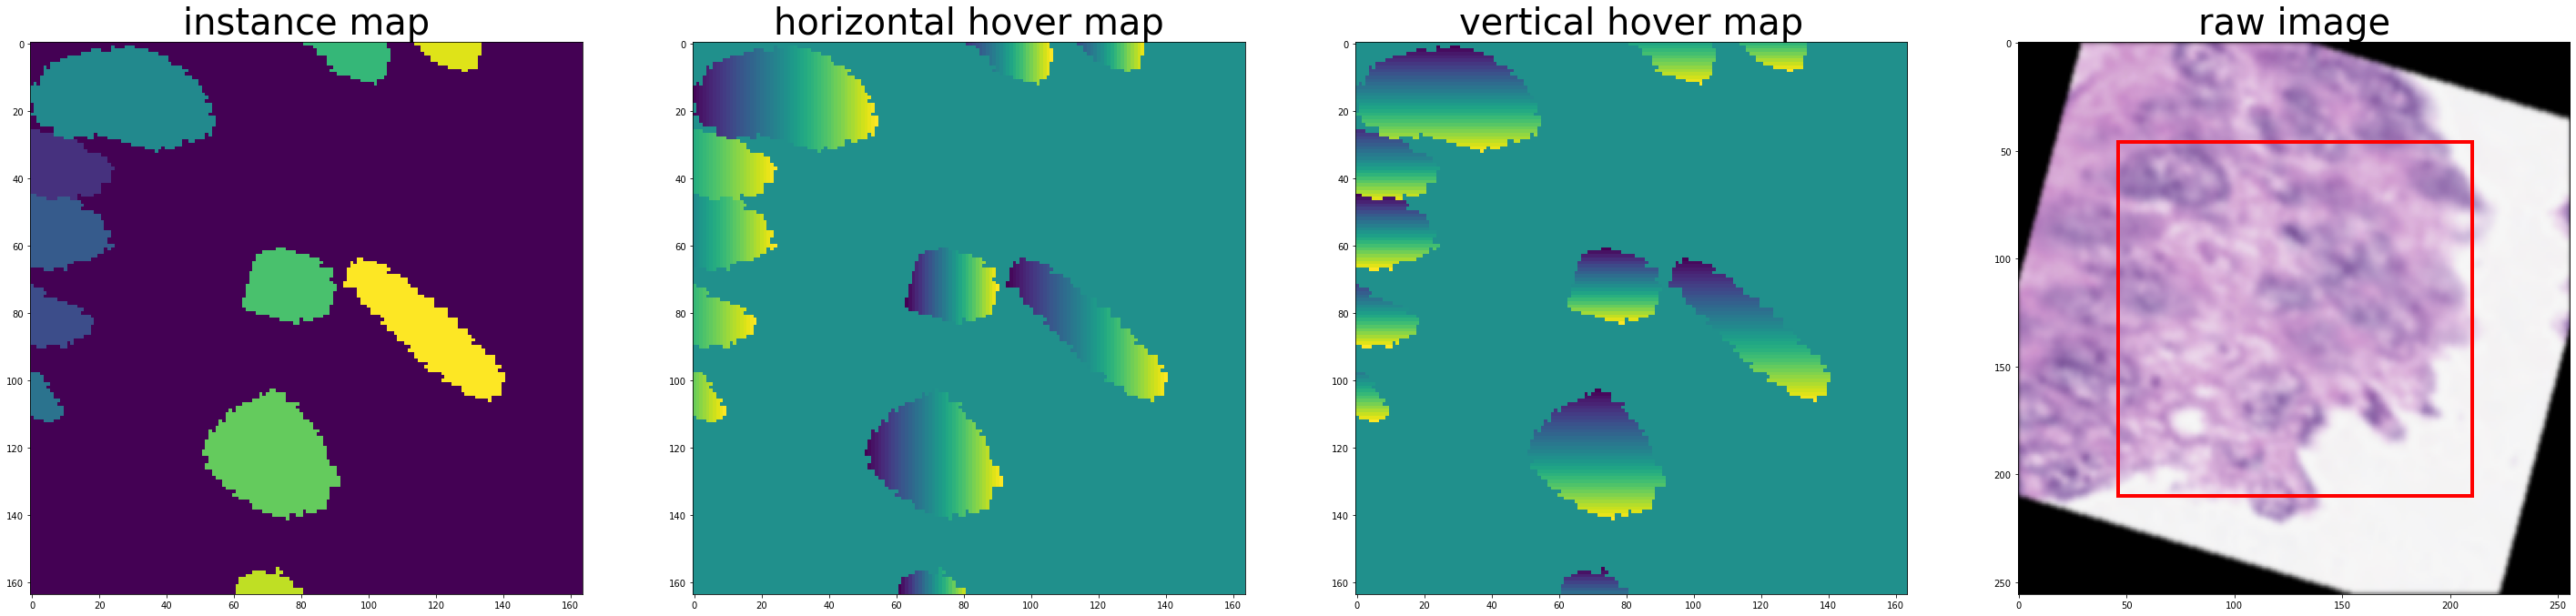

In [7]:
first_sample = first(train_loader)
for k in ("image", "label", "hover_label_inst"):
    print(f"{k}: ")
    print("    shape", first_sample[k].shape)
    print("    type: ", type(first_sample[k]))
    print("    dtype: ", first_sample[k].dtype)
print(f"train number of batches: {len(train_loader)}")
print(f"valid number of batches: {len(val_loader)}")

fig, ax = plt.subplots(1, 4, figsize=(50, 25))
raw_image = (first_sample["image"][0, ...] * 255).astype(np.uint8).transpose(1, 2, 0)

ax[0].imshow(first_sample["label_inst"][0, ...].squeeze())
ax[1].imshow(first_sample["hover_label_inst"][0, 0, ...])
ax[2].imshow(first_sample["hover_label_inst"][0, 1, ...])
ax[3].imshow(raw_image)
ax[3].add_patch(Rectangle((46, 46), 164, 164, fill=False, edgecolor="red", linewidth=4))
ax[0].set_title("instance map", fontsize=40)
ax[1].set_title("horizontal hover map", fontsize=40)
ax[2].set_title("vertical hover map", fontsize=40)
ax[3].set_title("raw image", fontsize=40)

In [8]:
stage = 0
device = torch.device("cuda")

def create_model(stage, device):
    if stage == 0:
        model = HoVerNet(
            mode="fast",
            in_channels=3,
            out_classes=out_classes,
            act=("relu", {"inplace": True}),
            norm="batch",
            pretrained_url=pretrained_model,
            freeze_encoder=True,
        )
        model.to(device)
        model = nn.DataParallel(model)
        print(f"stage{stage} start!")
    else:
        model = HoVerNet(
            mode="fast",
            in_channels=3,
            out_classes=out_classes,
            act=("relu", {"inplace": True}),
            norm="batch",
            pretrained_url=None,
            freeze_encoder=False,
        )
        model.to(device)
        model = nn.DataParallel(model)
        model.load_state_dict(torch.load(model_dir + f"model_{int(max_epochs/2 - 1)}.pth"))
        print(f"stage {stage}, success load weight!")

    return model

model = create_model(stage, device)
loss_function = HoVerNetLoss(lambda_hv_mse=1.0)

# lizard dataset
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

dice_metric = DiceMetric(include_background=False, reduction="mean")

2023-11-07 18:06:59,521 - INFO - Expected md5 is None, skip md5 check for file /home/eqp6pg/.cache/torch/hub/preact-resnet50.pth.
2023-11-07 18:06:59,522 - INFO - File exists: /home/eqp6pg/.cache/torch/hub/preact-resnet50.pth, skipped downloading.
249 out of 797 keys are updated with pretrained weights.
stage0 start!


In [9]:
amp = True
scaler = GradScaler()
val_interval = 2
post_process_np = Compose([Activations(softmax=True), AsDiscrete(argmax=True)])
total_start = time.time()
globel_step = 0
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    if epoch == int(max_epochs/2):
        model = create_model(1, device)
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-5
        )
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)
    
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in tqdm(train_loader):
        step += 1
        globel_step += 1
        inputs, label, label_type, hover_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["label_type"].to(device),
            batch_data["hover_label_inst"].to(device),
        )
        
        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: label_type,
        }
        
        optimizer.zero_grad()
        if amp:
            with autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        torch.cuda.empty_cache()
        model.eval()
        
        with torch.no_grad():
            for val_data in tqdm(val_loader):
                val_inputs, val_label = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                with torch.cuda.amp.autocast(enabled=amp):
                    val_outputs = model(val_inputs)

                # hover origin post
                val_outputs = [post_process_np(i[HoVerNetBranch.NP.value]) for i in decollate_batch(val_outputs)]
                val_label = decollate_batch(val_label)

                dice_metric(y_pred=val_outputs, y=val_label)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            metric_values.append(metric)
            torch.save(model.state_dict(), model_dir + f"model_{epoch}.pth")
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}")

        torch.cuda.empty_cache()

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    
    with open(model_dir + 'epoch_loss_values.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows([[value] for value in epoch_loss_values])
    
    with open(model_dir + 'metric_values.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows([[value] for value in metric_values])
    
total_time = time.time() - total_start
print(f"train completed, final epoch dice: {metric:.4f} " f"total time: {total_time}")

----------
epoch 1/200


100%|██████████| 135/135 [02:09<00:00,  1.04it/s]


epoch 1 average loss: 7.3496
time consuming of epoch 1 is: 129.3140
----------
epoch 2/200


100%|██████████| 135/135 [01:57<00:00,  1.15it/s]


epoch 2 average loss: 6.2592


100%|██████████| 43/43 [00:17<00:00,  2.50it/s]


current epoch: 2 current mean dice: 0.6686
time consuming of epoch 2 is: 136.0705
----------
epoch 3/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 3 average loss: 5.8673
time consuming of epoch 3 is: 115.5795
----------
epoch 4/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 4 average loss: 5.5839


100%|██████████| 43/43 [00:17<00:00,  2.45it/s]


current epoch: 4 current mean dice: 0.7012
time consuming of epoch 4 is: 134.0417
----------
epoch 5/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 5 average loss: 5.3543
time consuming of epoch 5 is: 115.5145
----------
epoch 6/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 6 average loss: 5.1679


100%|██████████| 43/43 [00:17<00:00,  2.42it/s]


current epoch: 6 current mean dice: 0.7325
time consuming of epoch 6 is: 134.5309
----------
epoch 7/200


100%|██████████| 135/135 [01:55<00:00,  1.16it/s]


epoch 7 average loss: 5.0066
time consuming of epoch 7 is: 115.9190
----------
epoch 8/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 8 average loss: 4.8765


100%|██████████| 43/43 [00:17<00:00,  2.42it/s]


current epoch: 8 current mean dice: 0.7288
time consuming of epoch 8 is: 135.6521
----------
epoch 9/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 9 average loss: 4.7581
time consuming of epoch 9 is: 115.1538
----------
epoch 10/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 10 average loss: 4.6730


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 10 current mean dice: 0.7407
time consuming of epoch 10 is: 136.0302
----------
epoch 11/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 11 average loss: 4.6076
time consuming of epoch 11 is: 116.8391
----------
epoch 12/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 12 average loss: 4.5812


100%|██████████| 43/43 [00:17<00:00,  2.42it/s]


current epoch: 12 current mean dice: 0.7449
time consuming of epoch 12 is: 134.4562
----------
epoch 13/200


100%|██████████| 135/135 [01:58<00:00,  1.14it/s]


epoch 13 average loss: 4.4866
time consuming of epoch 13 is: 118.2971
----------
epoch 14/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 14 average loss: 4.4632


100%|██████████| 43/43 [00:17<00:00,  2.41it/s]


current epoch: 14 current mean dice: 0.7509
time consuming of epoch 14 is: 134.7070
----------
epoch 15/200


100%|██████████| 135/135 [01:58<00:00,  1.14it/s]


epoch 15 average loss: 4.4457
time consuming of epoch 15 is: 118.9079
----------
epoch 16/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 16 average loss: 4.3938


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 16 current mean dice: 0.7577
time consuming of epoch 16 is: 134.3862
----------
epoch 17/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 17 average loss: 4.3708
time consuming of epoch 17 is: 114.8799
----------
epoch 18/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 18 average loss: 4.3701


100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


current epoch: 18 current mean dice: 0.7612
time consuming of epoch 18 is: 133.9833
----------
epoch 19/200


100%|██████████| 135/135 [01:54<00:00,  1.17it/s]


epoch 19 average loss: 4.3260
time consuming of epoch 19 is: 114.9923
----------
epoch 20/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 20 average loss: 4.2947


100%|██████████| 43/43 [00:17<00:00,  2.45it/s]


current epoch: 20 current mean dice: 0.7618
time consuming of epoch 20 is: 133.7267
----------
epoch 21/200


100%|██████████| 135/135 [01:55<00:00,  1.16it/s]


epoch 21 average loss: 4.2519
time consuming of epoch 21 is: 115.9762
----------
epoch 22/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 22 average loss: 4.2432


100%|██████████| 43/43 [00:17<00:00,  2.41it/s]


current epoch: 22 current mean dice: 0.7636
time consuming of epoch 22 is: 135.4066
----------
epoch 23/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 23 average loss: 4.2464
time consuming of epoch 23 is: 116.8864
----------
epoch 24/200


100%|██████████| 135/135 [01:57<00:00,  1.15it/s]


epoch 24 average loss: 4.2418


100%|██████████| 43/43 [00:17<00:00,  2.48it/s]


current epoch: 24 current mean dice: 0.7653
time consuming of epoch 24 is: 135.8080
----------
epoch 25/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 25 average loss: 4.1804
time consuming of epoch 25 is: 116.6115
----------
epoch 26/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 26 average loss: 4.1094


100%|██████████| 43/43 [00:17<00:00,  2.49it/s]


current epoch: 26 current mean dice: 0.7712
time consuming of epoch 26 is: 134.5767
----------
epoch 27/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 27 average loss: 4.1143
time consuming of epoch 27 is: 116.2793
----------
epoch 28/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 28 average loss: 4.0900


100%|██████████| 43/43 [00:17<00:00,  2.49it/s]


current epoch: 28 current mean dice: 0.7734
time consuming of epoch 28 is: 132.7254
----------
epoch 29/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 29 average loss: 4.0311
time consuming of epoch 29 is: 116.5762
----------
epoch 30/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 30 average loss: 3.9938


100%|██████████| 43/43 [00:17<00:00,  2.43it/s]


current epoch: 30 current mean dice: 0.7720
time consuming of epoch 30 is: 135.4145
----------
epoch 31/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 31 average loss: 4.0454
time consuming of epoch 31 is: 115.1569
----------
epoch 32/200


100%|██████████| 135/135 [01:57<00:00,  1.15it/s]


epoch 32 average loss: 4.0028


100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


current epoch: 32 current mean dice: 0.7712
time consuming of epoch 32 is: 136.5363
----------
epoch 33/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 33 average loss: 4.0333
time consuming of epoch 33 is: 114.5784
----------
epoch 34/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 34 average loss: 3.9813


100%|██████████| 43/43 [00:17<00:00,  2.40it/s]


current epoch: 34 current mean dice: 0.7740
time consuming of epoch 34 is: 135.8034
----------
epoch 35/200


100%|██████████| 135/135 [01:57<00:00,  1.15it/s]


epoch 35 average loss: 4.0104
time consuming of epoch 35 is: 117.2320
----------
epoch 36/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 36 average loss: 3.9735


100%|██████████| 43/43 [00:17<00:00,  2.47it/s]


current epoch: 36 current mean dice: 0.7735
time consuming of epoch 36 is: 133.6149
----------
epoch 37/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 37 average loss: 3.9862
time consuming of epoch 37 is: 115.7849
----------
epoch 38/200


100%|██████████| 135/135 [01:53<00:00,  1.18it/s]


epoch 38 average loss: 3.9907


100%|██████████| 43/43 [00:17<00:00,  2.41it/s]


current epoch: 38 current mean dice: 0.7733
time consuming of epoch 38 is: 133.4928
----------
epoch 39/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 39 average loss: 3.9861
time consuming of epoch 39 is: 116.5270
----------
epoch 40/200


100%|██████████| 135/135 [01:57<00:00,  1.15it/s]


epoch 40 average loss: 4.0213


100%|██████████| 43/43 [00:17<00:00,  2.45it/s]


current epoch: 40 current mean dice: 0.7744
time consuming of epoch 40 is: 136.9014
----------
epoch 41/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 41 average loss: 3.9571
time consuming of epoch 41 is: 114.2871
----------
epoch 42/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 42 average loss: 3.9577


100%|██████████| 43/43 [00:17<00:00,  2.43it/s]


current epoch: 42 current mean dice: 0.7743
time consuming of epoch 42 is: 133.3414
----------
epoch 43/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 43 average loss: 3.9701
time consuming of epoch 43 is: 114.2253
----------
epoch 44/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 44 average loss: 3.9605


100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


current epoch: 44 current mean dice: 0.7741
time consuming of epoch 44 is: 134.4327
----------
epoch 45/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 45 average loss: 3.9537
time consuming of epoch 45 is: 115.1659
----------
epoch 46/200


100%|██████████| 135/135 [01:54<00:00,  1.17it/s]


epoch 46 average loss: 3.9470


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 46 current mean dice: 0.7746
time consuming of epoch 46 is: 134.1167
----------
epoch 47/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 47 average loss: 3.9734
time consuming of epoch 47 is: 114.5648
----------
epoch 48/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 48 average loss: 3.9872


100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


current epoch: 48 current mean dice: 0.7754
time consuming of epoch 48 is: 133.3069
----------
epoch 49/200


100%|██████████| 135/135 [01:54<00:00,  1.18it/s]


epoch 49 average loss: 3.9257
time consuming of epoch 49 is: 114.0927
----------
epoch 50/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 50 average loss: 3.9264


100%|██████████| 43/43 [00:17<00:00,  2.42it/s]


current epoch: 50 current mean dice: 0.7760
time consuming of epoch 50 is: 134.8826
----------
epoch 51/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 51 average loss: 3.9536
time consuming of epoch 51 is: 116.4620
----------
epoch 52/200


100%|██████████| 135/135 [01:56<00:00,  1.16it/s]


epoch 52 average loss: 3.8861


100%|██████████| 43/43 [00:17<00:00,  2.47it/s]


current epoch: 52 current mean dice: 0.7764
time consuming of epoch 52 is: 135.4402
----------
epoch 53/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 53 average loss: 3.9047
time consuming of epoch 53 is: 115.0534
----------
epoch 54/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 54 average loss: 3.9464


100%|██████████| 43/43 [00:17<00:00,  2.45it/s]


current epoch: 54 current mean dice: 0.7749
time consuming of epoch 54 is: 134.2816
----------
epoch 55/200


100%|██████████| 135/135 [01:55<00:00,  1.17it/s]


epoch 55 average loss: 3.9119
time consuming of epoch 55 is: 115.5444
----------
epoch 56/200


100%|██████████| 135/135 [01:57<00:00,  1.15it/s]


epoch 56 average loss: 3.9421


100%|██████████| 135/135 [02:06<00:00,  1.06it/s]


epoch 141 average loss: 2.8857
time consuming of epoch 141 is: 126.9737
----------
epoch 142/200


100%|██████████| 135/135 [02:05<00:00,  1.08it/s]


epoch 142 average loss: 2.8410


100%|██████████| 43/43 [00:17<00:00,  2.45it/s]


current epoch: 142 current mean dice: 0.8040
time consuming of epoch 142 is: 144.2930
----------
epoch 143/200


100%|██████████| 135/135 [02:06<00:00,  1.06it/s]


epoch 143 average loss: 2.8722
time consuming of epoch 143 is: 126.9529
----------
epoch 144/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 144 average loss: 2.8396


100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


current epoch: 144 current mean dice: 0.8047
time consuming of epoch 144 is: 145.4159
----------
epoch 145/200


100%|██████████| 135/135 [02:06<00:00,  1.06it/s]


epoch 145 average loss: 2.8280
time consuming of epoch 145 is: 126.9077
----------
epoch 146/200


100%|██████████| 135/135 [02:05<00:00,  1.08it/s]


epoch 146 average loss: 2.8162


100%|██████████| 43/43 [00:17<00:00,  2.45it/s]


current epoch: 146 current mean dice: 0.8050
time consuming of epoch 146 is: 144.1742
----------
epoch 147/200


100%|██████████| 135/135 [02:05<00:00,  1.07it/s]


epoch 147 average loss: 2.8190
time consuming of epoch 147 is: 125.9454
----------
epoch 148/200


100%|██████████| 135/135 [02:07<00:00,  1.06it/s]


epoch 148 average loss: 2.7939


100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


current epoch: 148 current mean dice: 0.8056
time consuming of epoch 148 is: 146.2371
----------
epoch 149/200


100%|██████████| 135/135 [02:06<00:00,  1.06it/s]


epoch 149 average loss: 2.8049
time consuming of epoch 149 is: 127.0013
----------
epoch 150/200


100%|██████████| 135/135 [02:05<00:00,  1.07it/s]


epoch 150 average loss: 2.8103


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 150 current mean dice: 0.8047
time consuming of epoch 150 is: 145.0108
----------
epoch 151/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 151 average loss: 2.7655
time consuming of epoch 151 is: 126.7532
----------
epoch 152/200


100%|██████████| 135/135 [02:04<00:00,  1.08it/s]


epoch 152 average loss: 2.7392


100%|██████████| 43/43 [00:17<00:00,  2.45it/s]


current epoch: 152 current mean dice: 0.8048
time consuming of epoch 152 is: 144.1174
----------
epoch 153/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 153 average loss: 2.7487
time consuming of epoch 153 is: 126.5419
----------
epoch 154/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 154 average loss: 2.7341


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 154 current mean dice: 0.8053
time consuming of epoch 154 is: 145.5784
----------
epoch 155/200


100%|██████████| 135/135 [02:06<00:00,  1.06it/s]


epoch 155 average loss: 2.7761
time consuming of epoch 155 is: 126.8326
----------
epoch 156/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 156 average loss: 2.7496


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 156 current mean dice: 0.8052
time consuming of epoch 156 is: 145.2619
----------
epoch 157/200


100%|██████████| 135/135 [02:06<00:00,  1.06it/s]


epoch 157 average loss: 2.7606
time consuming of epoch 157 is: 126.7930
----------
epoch 158/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 158 average loss: 2.7511


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 158 current mean dice: 0.8048
time consuming of epoch 158 is: 145.1975
----------
epoch 159/200


100%|██████████| 135/135 [02:05<00:00,  1.07it/s]


epoch 159 average loss: 2.7487
time consuming of epoch 159 is: 125.7681
----------
epoch 160/200


100%|██████████| 135/135 [02:05<00:00,  1.07it/s]


epoch 160 average loss: 2.7403


100%|██████████| 43/43 [00:17<00:00,  2.43it/s]


current epoch: 160 current mean dice: 0.8054
time consuming of epoch 160 is: 145.0406
----------
epoch 161/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 161 average loss: 2.7267
time consuming of epoch 161 is: 126.5917
----------
epoch 162/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 162 average loss: 2.7594


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 162 current mean dice: 0.8054
time consuming of epoch 162 is: 145.2753
----------
epoch 163/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 163 average loss: 2.7339
time consuming of epoch 163 is: 126.2536
----------
epoch 164/200


100%|██████████| 135/135 [02:04<00:00,  1.08it/s]


epoch 164 average loss: 2.7460


100%|██████████| 43/43 [00:17<00:00,  2.40it/s]


current epoch: 164 current mean dice: 0.8057
time consuming of epoch 164 is: 144.4999
----------
epoch 165/200


100%|██████████| 135/135 [02:05<00:00,  1.07it/s]


epoch 166 average loss: 2.7381


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 166 current mean dice: 0.8056
time consuming of epoch 166 is: 144.8062
----------
epoch 167/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 167 average loss: 2.7133
time consuming of epoch 167 is: 126.6063
----------
epoch 168/200


100%|██████████| 135/135 [02:05<00:00,  1.08it/s]


epoch 168 average loss: 2.7630


100%|██████████| 43/43 [00:17<00:00,  2.48it/s]


current epoch: 168 current mean dice: 0.8054
time consuming of epoch 168 is: 143.7000
----------
epoch 169/200


100%|██████████| 135/135 [02:05<00:00,  1.08it/s]


epoch 169 average loss: 2.7597
time consuming of epoch 169 is: 125.3513
----------
epoch 170/200


100%|██████████| 135/135 [02:05<00:00,  1.08it/s]


epoch 170 average loss: 2.7672


100%|██████████| 43/43 [00:17<00:00,  2.40it/s]


current epoch: 170 current mean dice: 0.8062
time consuming of epoch 170 is: 144.8750
----------
epoch 171/200


100%|██████████| 135/135 [02:07<00:00,  1.06it/s]


epoch 171 average loss: 2.7039
time consuming of epoch 171 is: 127.2126
----------
epoch 172/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 172 average loss: 2.7122


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 172 current mean dice: 0.8065
time consuming of epoch 172 is: 145.5925
----------
epoch 173/200


100%|██████████| 135/135 [02:05<00:00,  1.08it/s]


epoch 173 average loss: 2.7220
time consuming of epoch 173 is: 125.2833
----------
epoch 174/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 174 average loss: 2.7351


100%|██████████| 43/43 [00:17<00:00,  2.48it/s]


current epoch: 174 current mean dice: 0.8058
time consuming of epoch 174 is: 144.9567
----------
epoch 175/200


100%|██████████| 135/135 [02:07<00:00,  1.06it/s]


epoch 175 average loss: 2.7163
time consuming of epoch 175 is: 127.3085
----------
epoch 176/200


100%|██████████| 135/135 [02:05<00:00,  1.07it/s]


epoch 176 average loss: 2.7096


100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


current epoch: 176 current mean dice: 0.8063
time consuming of epoch 176 is: 145.0524
----------
epoch 177/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 177 average loss: 2.7352
time consuming of epoch 177 is: 126.2622
----------
epoch 178/200


100%|██████████| 135/135 [02:08<00:00,  1.05it/s]


epoch 178 average loss: 2.6924


100%|██████████| 43/43 [00:17<00:00,  2.43it/s]


current epoch: 178 current mean dice: 0.8056
time consuming of epoch 178 is: 147.1490
----------
epoch 179/200


100%|██████████| 135/135 [02:05<00:00,  1.08it/s]


epoch 179 average loss: 2.6937
time consuming of epoch 179 is: 125.5709
----------
epoch 180/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 180 average loss: 2.7160


100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


current epoch: 180 current mean dice: 0.8056
time consuming of epoch 180 is: 145.9889
----------
epoch 181/200


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


epoch 181 average loss: 2.7510
time consuming of epoch 181 is: 126.0064
----------
epoch 182/200


100%|██████████| 135/135 [02:06<00:00,  1.06it/s]


epoch 182 average loss: 2.7086


100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


current epoch: 182 current mean dice: 0.8059
time consuming of epoch 182 is: 145.7253
----------
epoch 183/200


100%|██████████| 135/135 [02:05<00:00,  1.07it/s]


epoch 183 average loss: 2.7202
time consuming of epoch 183 is: 125.8535
----------
epoch 184/200


 56%|█████▌    | 75/135 [01:11<00:53,  1.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



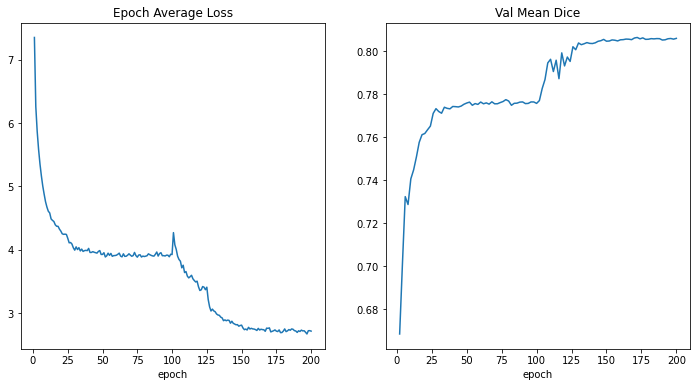

In [10]:
with open(model_dir + 'epoch_loss_values.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([[value] for value in epoch_loss_values])
    
with open(model_dir + 'metric_values.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([[value] for value in metric_values])

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [13]:
# Shuffle the instance id of the instance map for better visualisation
def shuffle_inst_map_id(instance_map):
    instance_id = list(np.unique(instance_map)[1:])  # exclude background
    new_instance_id = np.random.permutation(instance_id)
    new_instance_map = np.zeros(instance_map.shape)
    for i, _instance_id in enumerate(instance_id):
        new_instance_map[instance_map == _instance_id] = new_instance_id[i]
    return new_instance_map

100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


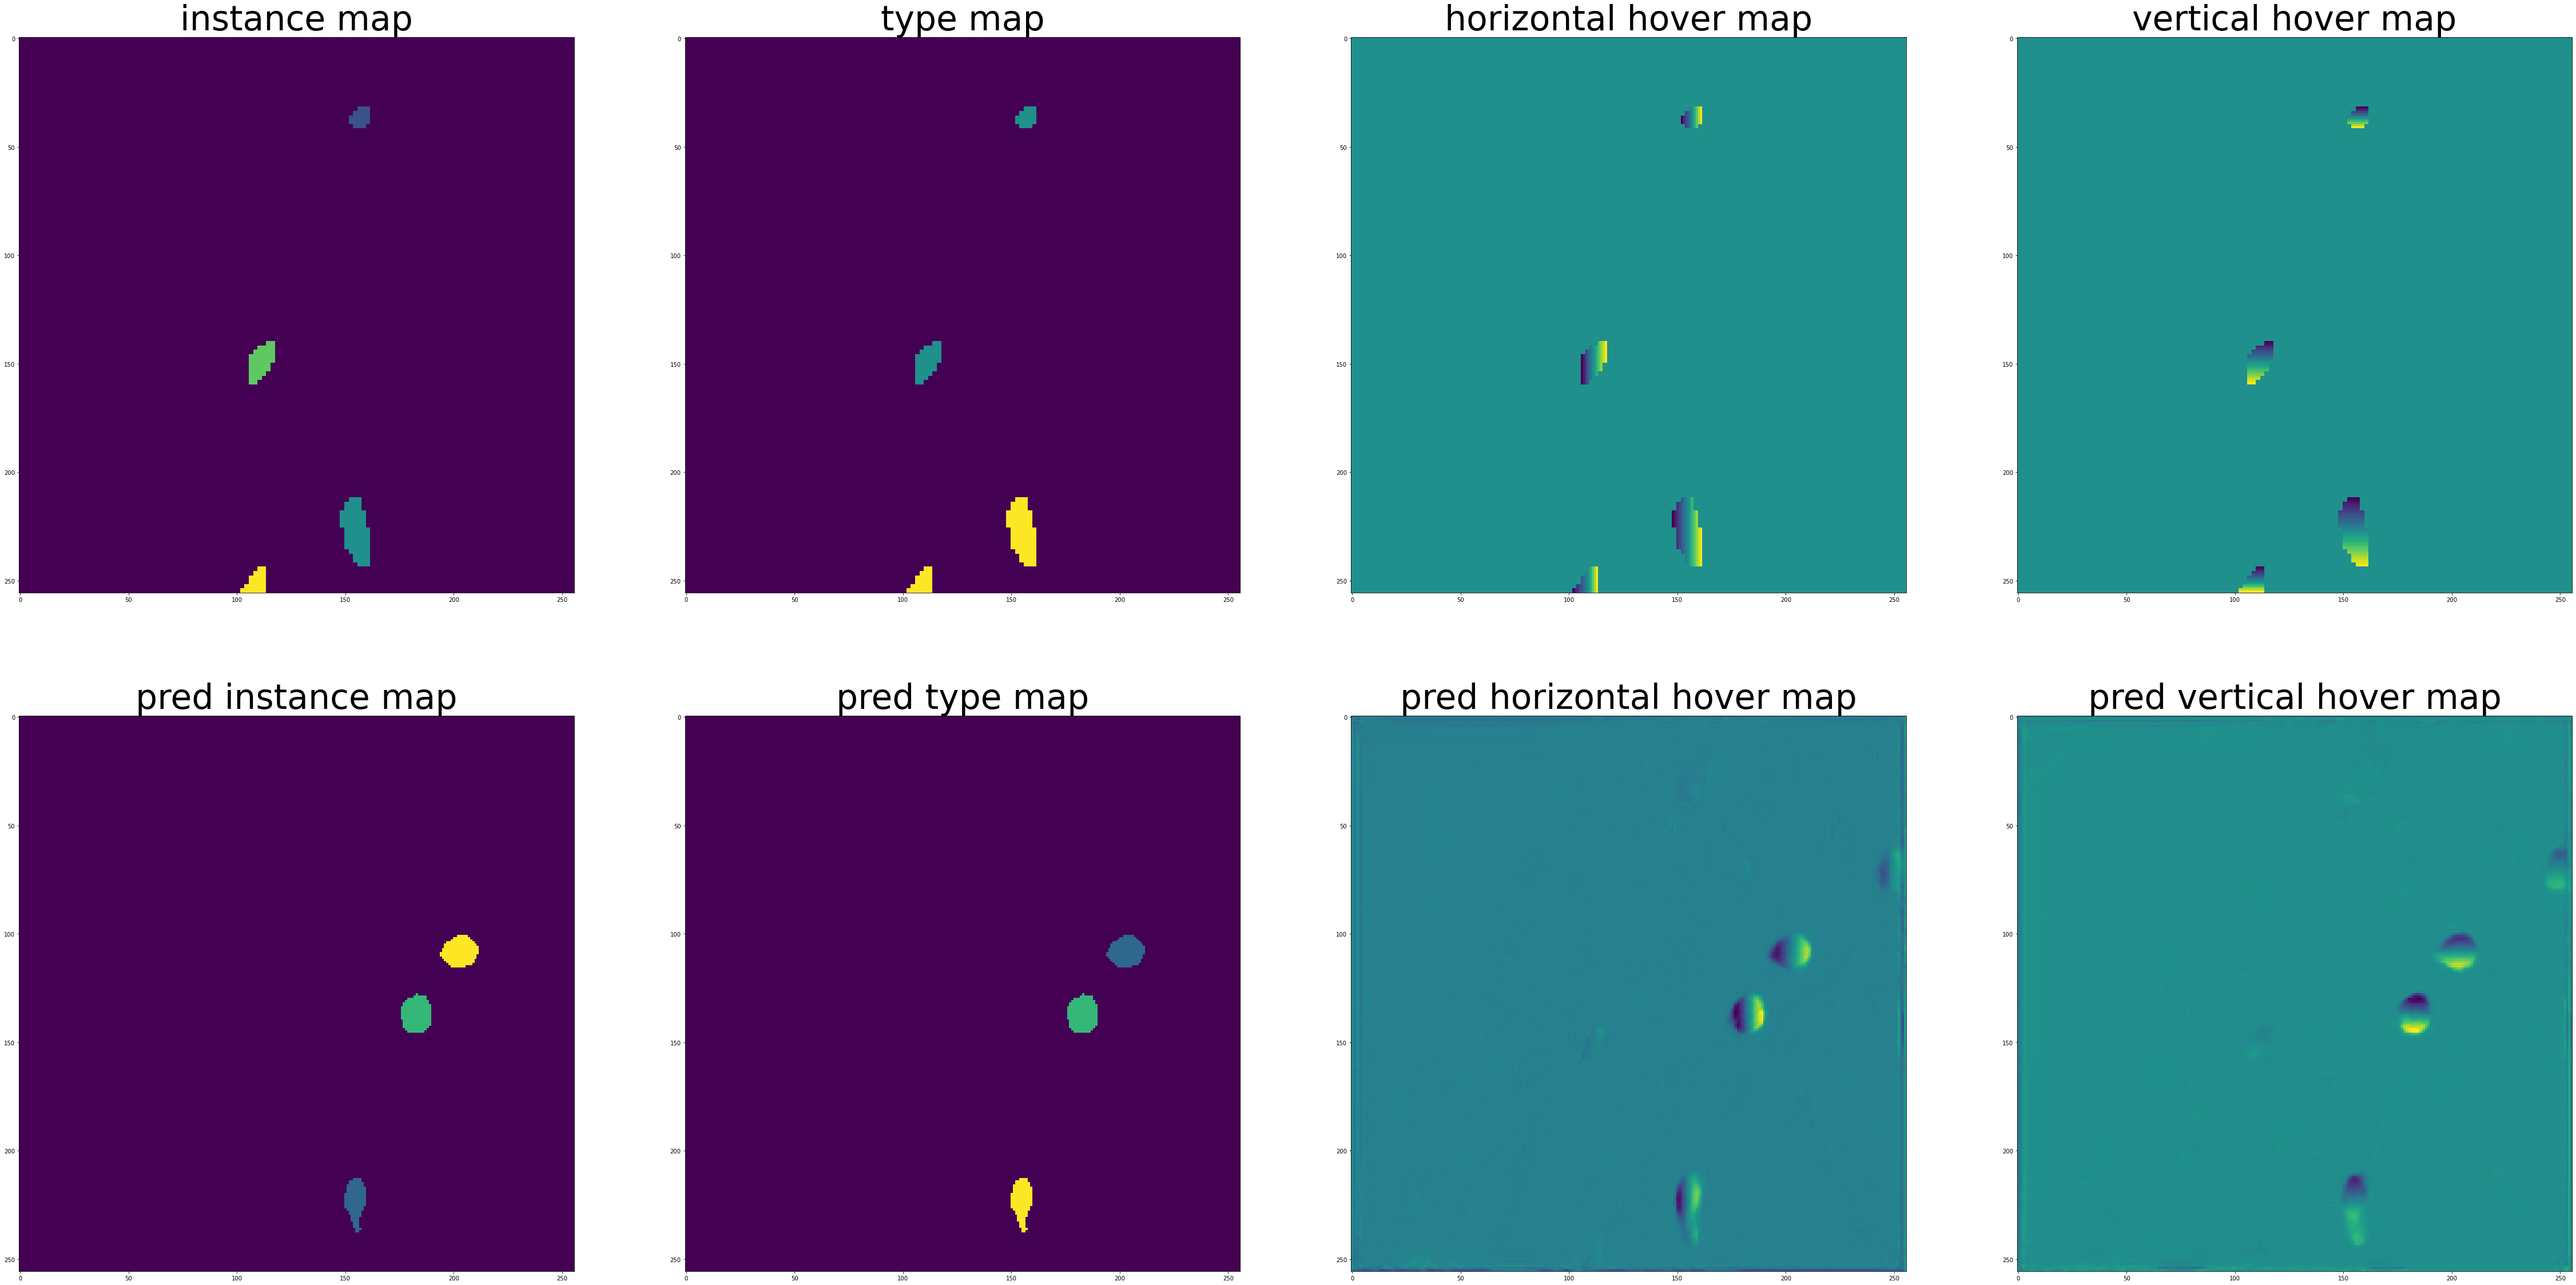

In [16]:
post_transforms = Compose(
    [
        HoVerNetInstanceMapPostProcessingd(sobel_kernel_size=21, marker_threshold=0.4, marker_radius=2),
        HoVerNetNuclearTypePostProcessingd(),
    ]
)

model.load_state_dict(torch.load(model_dir + "model_99.pth"))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    valid_ds = Dataset(data=valid_data[:10], transform=infer_transforms)
    val_data = valid_ds[0]
    val_input = val_data["image"].unsqueeze(0).to(device)

    sliding_inferer = SlidingWindowHoVerNetInferer(
        roi_size=256,
        sw_batch_size=8,
        overlap=1.0 - float(164) / float(256),
        padding_mode="constant",
        cval=0,
        sw_device=device,
        device=device,
        progress=True,
        extra_input_padding=((256 - 164) // 2,) * 4,
    )
    val_output = sliding_inferer(val_input, model)
    val_output_ = [apply_transform(post_transforms, i) for i in decollate_batch(val_output)]

    label_inst_map = shuffle_inst_map_id(val_data["label_inst"].squeeze().detach().cpu().numpy())
    pred_inst_map = shuffle_inst_map_id(val_output_[0]["instance_map"].squeeze())

    fig, ax = plt.subplots(2, 4, figsize=(80, 40))
    ax[0, 0].imshow(label_inst_map)
    ax[0, 1].imshow(val_data["label_type"].squeeze().detach().cpu())
    ax[0, 2].imshow(val_data["hover_label_inst"][0, ...].detach().cpu())
    ax[0, 3].imshow(val_data["hover_label_inst"][1, ...].detach().cpu())
    
    ax[1, 0].imshow(pred_inst_map)
    ax[1, 1].imshow(val_output_[0]["type_map"].squeeze())
    ax[1, 2].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
    ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

    ax[0, 0].set_title("instance map", fontsize=60)
    ax[0, 1].set_title("type map", fontsize=60)
    ax[0, 2].set_title("horizontal hover map", fontsize=60)
    ax[0, 3].set_title("vertical hover map", fontsize=60)
    ax[1, 0].set_title("pred instance map", fontsize=60)
    ax[1, 1].set_title("pred type map", fontsize=60)
    ax[1, 2].set_title("pred horizontal hover map", fontsize=60)
    ax[1, 3].set_title("pred vertical hover map", fontsize=60)